# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2020
## Домашнее задание 3. Сравнение оценок и эффективные оценки
### Дедлайн --- 2 ноября 9:00

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Информация о выполнении и курсе в целом есть в <a href=https://docs.google.com/document/d/1kd85QRAS8fbxRxpMzP2IsbQ_YcVsU-Aczqd6ErXgIDg/edit#>этой папке</a>.

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде, 
* собственно кодом, 
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается **в 15 баллов**.

In [1]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid", font_scale=1.4)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задача 1

Сгенерируйте выборку из трех распределений: нормального, лапласа и коши размера `N=500`.

Далее для всех графиков в этом задании используйте обозначенные цвета для каждого из распределений (даже если графики будут на разных осях). То есть если график касается нормального распределения то рисуйте его синим цветом.

In [2]:
color_for_normal=sns.color_palette("colorblind")[0]
color_for_laplace=sns.color_palette("colorblind")[1]
color_for_cauchy=sns.color_palette("colorblind")[2]

N=500

norm_distr = sps.norm()
laplacian_distr = sps.laplace()
cauchy_distr = sps.cauchy()
np.random.seed(2020)

sample_norm = norm_distr.rvs(size=N)
sample_laplacian = laplacian_distr.rvs(size=N)
sample_cauchy = cauchy_distr.rvs(size=N)

Постройте график плотности распределения для всех трех распределений на одних осях.

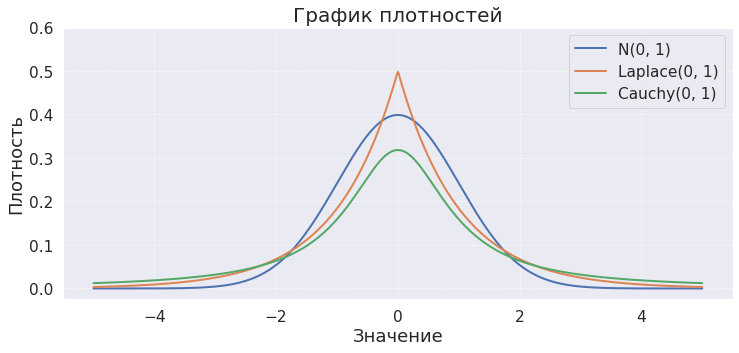

In [3]:
grid = np.linspace(-5, 5, 1000)
plt.figure(figsize=(12, 5))

plt.plot(grid, sps.norm.pdf(grid, loc=0, scale=1), lw=2, label='N(0, 1)')
plt.plot(grid, sps.laplace.pdf(grid, loc=0, scale=1), lw=2, label='Laplace(0, 1)')
plt.plot(grid, sps.cauchy.pdf(grid, loc=0, scale=1), lw=2, label='Cauchy(0, 1)')

plt.grid(ls=':')
plt.ylim((None, 0.6))

plt.xlabel('Значение', fontsize=18)
plt.ylabel('Плотность', fontsize=18)
plt.title('График плотностей', fontsize=20)
plt.legend()
plt.show()


Подумайте для каких распределений сложнее найти значение математического ожидания по выборке? Почему?

**Ответ:** 
Из ЗБЧ мы знаем, что среднее арифмитическое элементов выборки хорошо оценивает матожидание. Поэтому, чем "легче" хвосты у графика плотности распредления, тем проще найти матожидание по выборке.
Графики плотностей распределения Коши и Лапласа имеют "тяжёлые хвосты", поэтому матожидание по выборке будет искать сложно.
(в случае распределения Коши невозможно, т.к. конечного матожидания не существует)

Часто, в реальной жизни, мы сталкиваемся с данными в которых есть выбросы возникшие, например, из-за опечаток. Пусть в выборке содержится 99 точек на интервале $[0;1]$ и один элемент равный 300. Тогда среднее значение нашей выборки будет не меньше трех. Ясно, что так дело не пойдет, что же делать?

Можно использовать медиану или **усеченное среднее**.

**Усеченное среднее порядка $\alpha$** это среднее составленное из выборки от которой отрезаны $\alpha$ и $1 - \alpha$ квантили. Как ее получить?


1.   Отсортировать выборку
2.   Отрезать первые и последние ($\alpha \cdot \text{размер выборки}$) элементов выборки
3.   Посчитать среднее полученной выборки

Напишите функцию для подсчета этой статистики.

In [4]:
import math

def truncated_mean(sample, alpha=0.3):
    sample = np.sort(sample)
    sample = sample[round(alpha * len(sample)) : round(len(sample) * (1 - alpha))]
    return np.mean(sample)

**Теорема**
Пусть распределение симметрично относительно нуля и имеет одну моду в нуле, тогда асимптотическая дисперсия усеченного среднего порядка $\alpha$ может быть выражена по формуле:
$$
\sigma^2(\alpha) = 2\cdot\frac{\int_0^{u_{1 - \alpha}} x^2 dF(x) + \alpha\cdot(u_{1 - \alpha})^2}{(1 - 2\alpha)^2},
$$

где $u_\alpha$ – квантиль порядка $\alpha$.

Напишите функцию, которая это делает.

*Подсказка.* Для численного интегрирования используйте функцию `quad` из модуля `scipy.integrate`

In [5]:
from scipy.integrate import quad

def asymp_var(distr, alpha):
    quantile = distr.ppf(1 - alpha)
    f = lambda x : (x ** 2) * distr.pdf(x)
    integral, err = quad(f, 0, quantile)
    return 2 * (integral + alpha * (quantile) ** 2) / (1 - 2 * alpha) ** 2


Постройте графики для фсимптотической дисперсии в зависимости от $\alpha$ для всех трех распределений на назных осях (используйте `plt.subplots(1, 3, figsize=(21,7))`). **Не забудьте про цвета**. Для загаловка графика используйте `ax[i].set_title`, для заголовка всей картинки используйте `fig.suptitle`.

Text(0.5, 0.98, 'Графики для асимптотической дисперсии в зависимости от alpha')

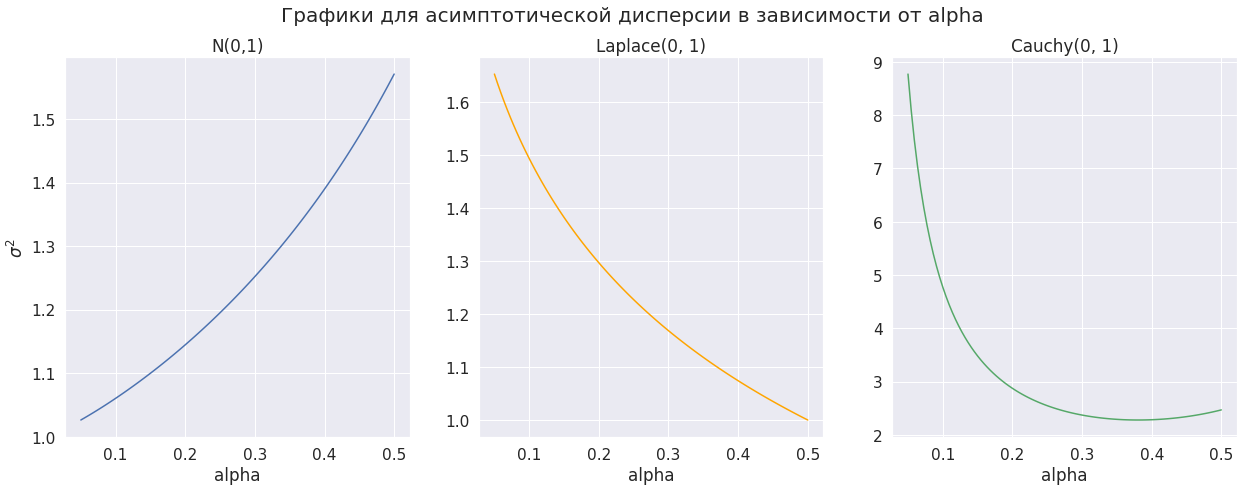

In [6]:
alpha_grid = np.linspace(0.05, 0.49999, 100)

asymp_vars_norm = np.array([asymp_var(norm_distr, alpha) for alpha in alpha_grid])
asymp_vars_laplace = np.array([asymp_var(laplacian_distr, alpha) for alpha in alpha_grid])
asymp_vars_cauchy = np.array([asymp_var(cauchy_distr, alpha) for alpha in alpha_grid])

fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].plot(alpha_grid, asymp_vars_norm, color='b')
ax[1].plot(alpha_grid, asymp_vars_laplace, color='orange')
ax[2].plot(alpha_grid, asymp_vars_cauchy, color='g')

ax[0].set_title('N(0,1)')
ax[1].set_title('Laplace(0, 1)')
ax[2].set_title('Cauchy(0, 1)')

for ax_i in ax.flat:
    ax_i.set(xlabel="alpha")
ax.flat[0].set(ylabel="$\sigma^2$")

fig.suptitle("Графики для асимптотической дисперсии в зависимости от alpha", fontsize=20)

Как можно интепретировать такой график? Напишите развернутый вывод.

*Подсказка.* Подумайте, какой известной оценке соответствует усеченное среднее порядка 0.5? А порядка 0?

**Ответ:**
Усеченное среднее порядка 0.5 соответсятвует медиане, а усеченное среднее порядка 1 - $\overline X$.

По графику видно, что для $N(0, 1)$ выборочное среднее примерно в полтора раза эффективнее медианы.Для рапределений Лапласа и Коши наоборот - медиана эффективнее выборочного среднего.

Эффективность медианы по сравнениию с $\overline X$ для распределений Лапласа и Коши связана с тем, что эти распределения имеют "тяжёлые хвосты", поэтому обладают большими выбросами, а медиана - устойчива к выбросам, в отличие от $\overline X$

Таким образом, для моделей с "лёгкими хвостами" медиана ведёт себя не очень удачно, т.к. отбрасывает большую часть выборки, но для моделей с "тяжёлыми хвостами" вполне удачно.


Для каждого распределение на отдельном графике постройте значение трех оценок: среднего, медианы и усученного среднего порядка $0.35$. Для усеченного среднего проведите линию пунктиром (`fmt="--"`), для медианы точечками (`fmt=":"`). **Не забудьте про цвета**. То есть цвета на одном графике одинаковые, разные оценки отличает только формат линии.

**Ниже посчитайте все оценки необходимые для всех распределений**

In [7]:
ALPHA = 0.35

estimate_mean_norm =  np.mean(sample_norm)
estimate_mean_laplace = np.mean(sample_laplacian)
estimate_mean_cauchy = np.mean(sample_cauchy)

esitamate_median_norm = np.median(sample_norm)
esitamate_median_laplace = np.median(sample_laplacian)
esitamate_median_cauchy = np.median(sample_cauchy)

esitamate_truncated_mean_norm = truncated_mean(sample_norm, ALPHA)
esitamate_truncated_mean_laplace = truncated_mean(sample_laplacian, ALPHA)
esitamate_truncated_mean_cauchy = truncated_mean(sample_cauchy, ALPHA)

def show_graphic(mean, median, truncated_mean, name_distr, color):
    plt.figure(figsize=(7, 5))
    plt.title('График значений оценок для {}(0, 1)'.format(name_distr), fontsize=20)
    plt.plot(np.array([mean, mean]), color=color, label="mean", lw=3)
    plt.plot(np.array([median, median]), color=color, dashes=[1, 1], label="median", lw=3)   
    plt.plot(np.array([truncated_mean, truncated_mean]), color=color, dashes=[4, 4], label="truncated mean 0.35", lw=3) 
    plt.ylabel('Значение оценки', fontsize=18)
    plt.legend()
    plt.show()

**Нормальное распределение**

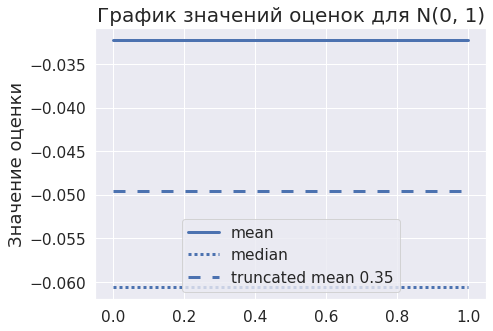

In [8]:
show_graphic(estimate_mean_norm, esitamate_median_norm, esitamate_truncated_mean_norm, 'N', 'b')

**Распределение Лапласа**

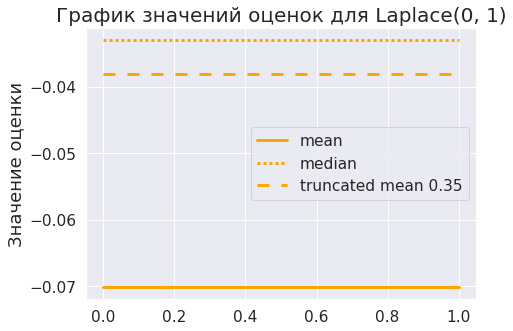

In [9]:
show_graphic(estimate_mean_laplace, esitamate_median_laplace, esitamate_truncated_mean_laplace, 'Laplace', 'orange')

**Распределение Коши**

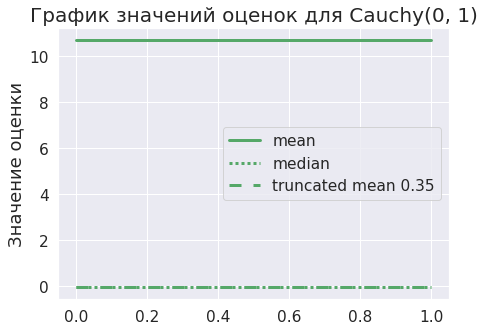

In [10]:
show_graphic(estimate_mean_cauchy, esitamate_median_cauchy, esitamate_truncated_mean_cauchy, 'Cauchy', 'g')

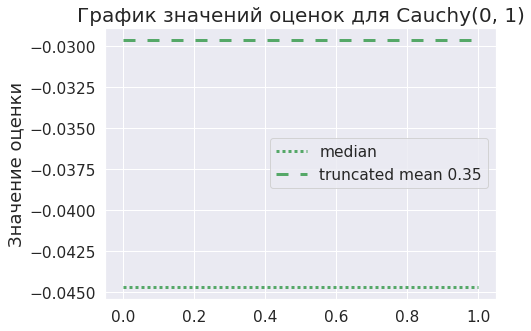

In [11]:
plt.figure(figsize=(7, 5))
plt.title('График значений оценок для Cauchy(0, 1)', fontsize=20)
plt.plot(np.array([esitamate_median_cauchy, esitamate_median_cauchy]), color='g', dashes=[1, 1], label="median", lw=3)   
plt.plot(np.array([esitamate_truncated_mean_cauchy, esitamate_truncated_mean_cauchy]), color='g', dashes=[4, 4], label="truncated mean 0.35", lw=3) 
plt.ylabel('Значение оценки', fontsize=18)
plt.legend()
plt.show()

Как эти три графика соотносятся с графиками асимптотической дисперсии усеченного среднего для всех этих распределений? Сделайте вывод.

**Вывод:**
- $N(0, 1)$: По графику видно, что чем больше данных учитывает оценка, тем она лучше.
- $Laplace(0, 1)$: Тут наоборот, за счет того, что распределение имеет большие выбросы, наилучшим поведением обладает медиана, а нихудшим выборочное среднее.
- $Cauchy(0, 1)$: Выборочное среднее ведёт себя очень плохо, а вот усеченное среднее и медиана хорошо, причем усеченное средее лучше.

Таким образом, графики полностью соответсятвуют графикам асимптотической дисперсии, полученным выше.

# Задача 2

## Wine dataset

Давайте загрузим и проанализируем датасет, состоящий из различных показателей для красного вина и оценок сомелье. 

In [63]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1LsNeROfnVQb2ksdtwZvxrZREdy_Z-jta

Downloading...
From: https://drive.google.com/uc?id=1LsNeROfnVQb2ksdtwZvxrZREdy_Z-jta
To: /home/tanya/Notebooks/stat/winequality-red.csv
100%|████████████████████████████████████████| 101k/101k [00:00<00:00, 2.34MB/s]


In [12]:
import pandas as pd

In [13]:
data = pd.read_csv("winequality-red.csv")

In [14]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Поделите вина на три категории по содержанию алкоголя. Добавьте колонку `"category"` со значениями `"low alcohol"`, `"medium alcohol"`, `"high alcohol"` для относительного объемного содержания алкоголя `x<=10`, `10 < x <= 12`, `x > 12` соответственно.

In [15]:
def categorizer(x):
    if x['alcohol'] <= 10:
        return 'low alcohol'
    if 10 < x['alcohol'] <= 12:
        return 'medium alcohol'
    return 'high alcohol'

data['category'] = data.apply(categorizer, axis=1)

Для каждой категории посчитайте среднее и медиану содержания остаточного сахара (`"residual sugar"`). Сделайте pandas.DataFrame с индексами в виде категории содержания алкоголя и колнками в виде среднего и медианы.

In [16]:
data.groupby('category')['residual sugar'].mean()
data.groupby('category')['residual sugar'].median()

df_mean = pd.DataFrame(data.groupby('category')['residual sugar'].mean())
df_mean.rename(columns={'residual sugar': 'mean'}, inplace=True)

df_median = pd.DataFrame(data.groupby('category')['residual sugar'].median())
df_median.rename(columns={'residual sugar': 'median'}, inplace=True)

df = pd.merge(df_mean, df_median, on='category')
df

,mean,median
category,,
high alcohol,2.760993,2.3
low alcohol,2.445984,2.1
medium alcohol,2.592264,2.2


Что можно сказать о распределении сахара по этим категориям? О распределении остаточного сахара в целом?

**Ответ:**
Чем выше содержание алкоголя, тем выше уровень остаточного сахара.

Постройте `boxplot` для остаточного сахара по категориям, полученным ранее на основании доли алкоголя.

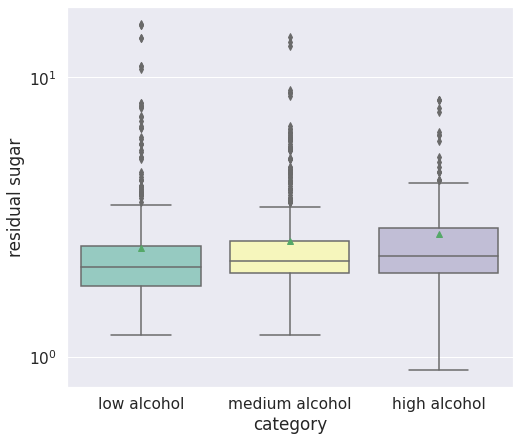

In [17]:
palette = sns.color_palette("viridis", n_colors=3)[::-1]

import seaborn as sns

plt.figure(figsize=(8, 7))
a = sns.boxplot(x='category', y='residual sugar', data=data, showmeans=True, palette='Set3')
a.set_yscale("log")

Как соотнясятся оценки из предыдущего пункта и график сверху? Что лучше использовать для оценивания содержания сахара: медииану или среднее? Почему?

**Ответ:**
График подтверждает верность оценок, полученных в предыдущем пункте.
Для оценивания содержания сахара лучше использовать медиану, т.к. имеется довольно много выбросов.

Постройте один `scatterplot` (используйте `seaborn`) для очень хороших и очень плохих вин (`quality == 3`, `quality == 8`) в зависимости от содержания алкоголя (`alcohol` **не** из предыдущего пункта, а из колонки исходного датасета) и от количества лимонной кислоты (`citric acid`). Используйте `palette=[palette[0]]+[palette[-1]]`.

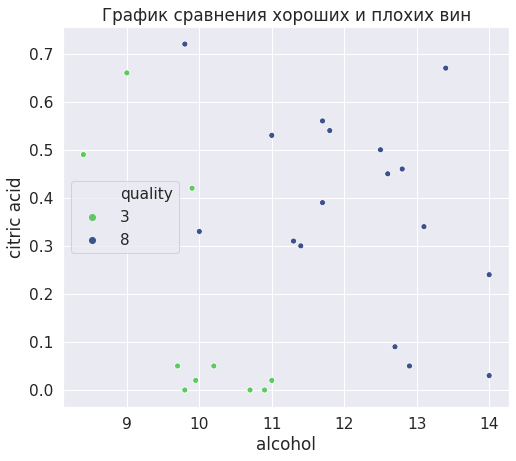

In [18]:
data_quality_bad = data[data.quality == 3]
data_quality_good = data[data.quality == 8]
data_quality_bad_and_good = data_quality_bad.append(data_quality_good)

plt.figure(figsize=(8, 7))
plt.title('График сравнения хороших и плохих вин')
sns.scatterplot(
    data=data_quality_bad_and_good,
    x="alcohol", y="citric acid", hue="quality",
    palette=[palette[0]]+[palette[-1]]
)

Найдите ОМП для двух этих распределений в предположении, что обе выбоки из многомерного нормального распределения. Не мудрите, $\mu$ и $\Sigma$ получаются в одну команду через `numpy`. Далее получите плотности для сетки `X`, `Y`. Используйте `sps.multivariate_normal`.

In [67]:
# считаем mu
mean_bad = np.array([
    np.mean(np.array(data_quality_bad["citric acid"])), 
    np.mean(np.array(data_quality_bad["alcohol"]))
])
mean_good = np.array([
    np.mean(np.array(data_quality_good["citric acid"])), 
    np.mean(np.array(data_quality_good["alcohol"]))
])

# находим ковариационную матрицу
cov_matrix_bad = np.cov(np.array(data_quality_bad["citric acid"]), np.array(data_quality_bad["alcohol"]))
cov_matrix_good = np.cov(np.array(data_quality_good["citric acid"]), np.array(data_quality_good["alcohol"]))

rv_bad = sps.multivariate_normal(mean_bad, cov_matrix_bad)
rv_good = sps.multivariate_normal(mean_good, cov_matrix_good)

x, y = np.mgrid[-0.5:1:.01, 8:15:.01]
pos = np.dstack((x, y))
bad_pdf = rv_bad.pdf(pos)
good_pdf = rv_good.pdf(pos)

Нарисуйте график плотности с линиями контура и нанесите точки выборки. Используйте зеленый цвет для вина плохого качества (`get_density_cmap("Greens")` и `"g"` для точек) и синий для вина хорошего качества (`get_density_cmap("Blues")` и `"b"`). Используйте функции `plt.pcolormesh`, `plt.clabel` и `plt.scatter`. Не забудьте про `plt.xlabel`, `plt.ylabel` и `plt.legend`.

In [68]:
from matplotlib.colors import ListedColormap

def get_density_cmap(name):
    cmap =  plt.get_cmap(name)
    cmap_col = cmap(np.arange(cmap.N))
    cmap_col[:, -1] = np.linspace(0, 1, cmap.N)**2
    return ListedColormap(cmap_col)

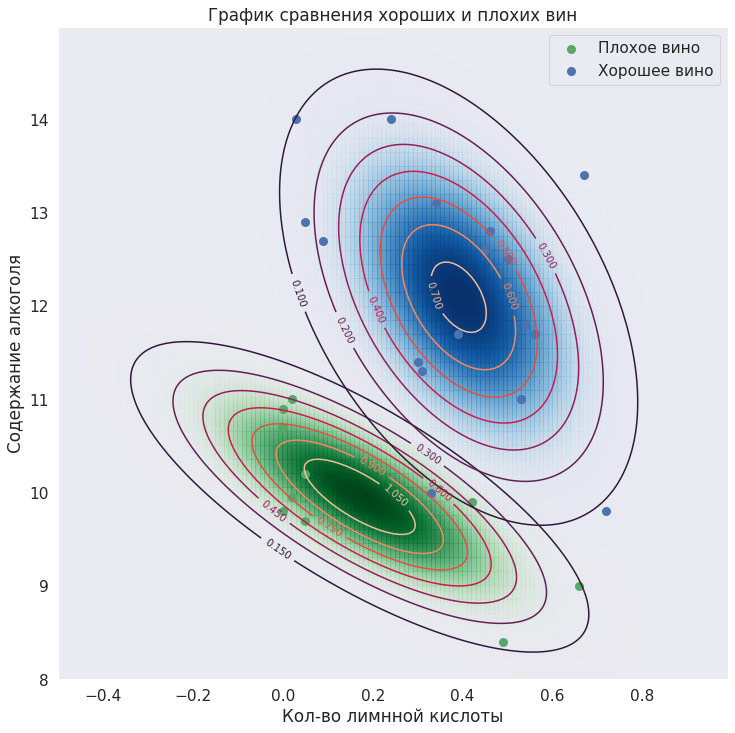

In [91]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.pcolormesh(x, y, bad_pdf, cmap=get_density_cmap("Greens"))
ax.pcolormesh(x, y, good_pdf, cmap=get_density_cmap("Blues"))

CS = ax.contour(x, y, bad_pdf)
ax.clabel(CS, inline=1)
CS = ax.contour(x, y, good_pdf)
ax.clabel(CS, inline=1)

ax.scatter(
    np.array(data_quality_bad['citric acid']),
    np.array(data_quality_bad['alcohol']),
    color='g',
    lw=3,
    label="Плохое вино"
)
ax.scatter(
    np.array(data_quality_good['citric acid']),
    np.array(data_quality_good['alcohol']),
    color='b',
    lw=3,
    label="Хорошее вино"
)
ax.set_title("График сравнения хороших и плохих вин")
ax.set(ylabel="Содержание алкоголя", xlabel="Кол-во лимнной кислоты")
plt.legend()

Что можно сказать о вине, которому сомелье дали наивысший балл по сравнению с вином, которому дали наименьший балл, основываясь на график выше?

**Ответ:**

В хорошем вине выше содержание алкоголя и немного больше лимонной кислоты.

# Задача 3

Рассмотрим $X_1, ..., X_n \sim Bern(\theta)$. По сетке значений $\theta \in
    [0, 1]$ с шагом 0.01 постройте график зависимости нижней оценки дисперсии
    произвольной несмещенной оценки из неравенства Рао-Крамера от $\theta$. 

**Решение:**

Неравенство Рао-Крамера:
$$
\frac{(\tau'(\theta))^2}{ni(\theta)} \leq D(\theta^*(X))
$$

$$
p_{\theta}(X) = \theta^{\sum X_i}(1-\theta)^{n-\sum X_i}
$$

$$
u_{\theta}(X) = \frac{\partial}{\partial\theta}\ln(p_{\theta}(X)) = \frac{n}{\theta(1-\theta)}(\overline{X}-\theta)
$$

По критерию эффективности:
$$
\frac{\theta(1-\theta)}{n} = \frac{1}{ni(\theta)}
$$

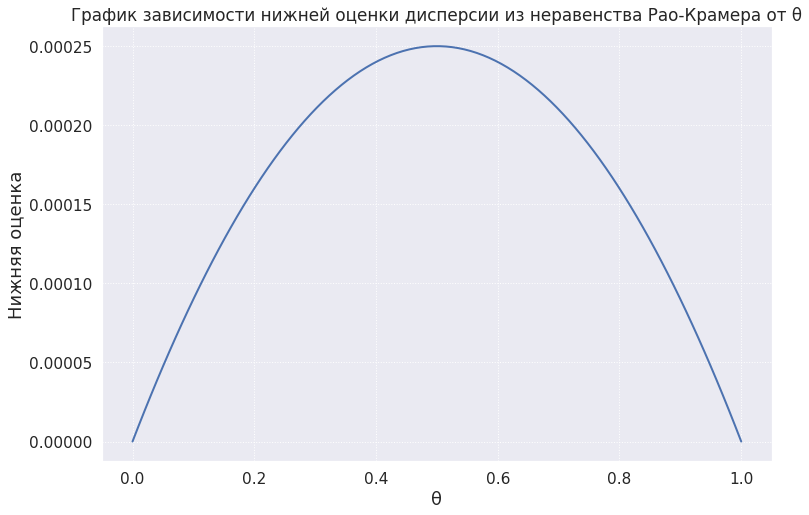

In [96]:
N = 1000
grid = np.linspace(0, 1, 100)

f = lambda x: x * (1 - x) / N
plt.figure(figsize=(12, 8))

plt.plot(grid, f(grid), lw=2)

plt.grid(ls=':')
#plt.ylim((None, 0.6))

plt.xlabel('θ', fontsize=18)
plt.ylabel('Нижняя оценка', fontsize=18)
plt.title('График зависимости нижней оценки дисперсии из неравенства Рао-Крамера от θ')
plt.show()

Какой можно сделать вывод (напишите в комментариях)?

**Вывод**
Чем ближе $\theta$ к 0.5, тем больше нижняя оценка дисперсии.

 Для каждого значения $\theta$
    (для той же сетки) сгенерируйте выборку размера $n=1000$ для параметра $\theta$,
    посчитайте эффективную оценку $\theta$ и бутстрепную оценку дисперсии
    (количество бутстрепных выборок равно $1000$) этой
    эффективной оценки $\theta$.

**Решение:**

Из кр. эффективности знаем, что для распределения Бернулли $\overline X$ - эффектиная оценка $\theta$

In [120]:
# генерация набора из K бутстрепных выборок
def generate_bootstrap_sample(sample, k):
    return np.array([np.random.choice(sample[0:k], k) for i in range(k)])

# считаем бутстрепную оценку дисперсии
def calc_bootstrap_esimate_var(sample):
    # генерируем бутстрепную выборку
    bootstrap_samples = generate_bootstrap_sample(sample, N)
    # для каждой выборки находим дисперсию эффективной оценки
    bootstrap_estimates = np.array([
        np.mean(bootstrap_sample) * (1 - np.mean(bootstrap_sample) )
        for bootstrap_sample in bootstrap_samples
    ])
    
    return np.mean(bootstrap_estimates)

In [121]:
# генерируем выборки
samples = np.array([sps.bernoulli.rvs(theta, size=N) for theta in grid])

# для каждой выборки находим эффективную оценку
effective_estimate = np.array([np.mean(sample) for sample in samples])

# для каждой выборки находим бутстрепную оценку дисперсии
bootstrap_estimates = np.array([np.mean(generate_bootstrap_sample(sample, N)) for sample in samples])

bootstrap_estimates = np.array([
     calc_bootstrap_esimate_var(sample) for sample in samples
])

 Нарисуйте график зависимости полученных бутстрепных оценок от $\theta$.

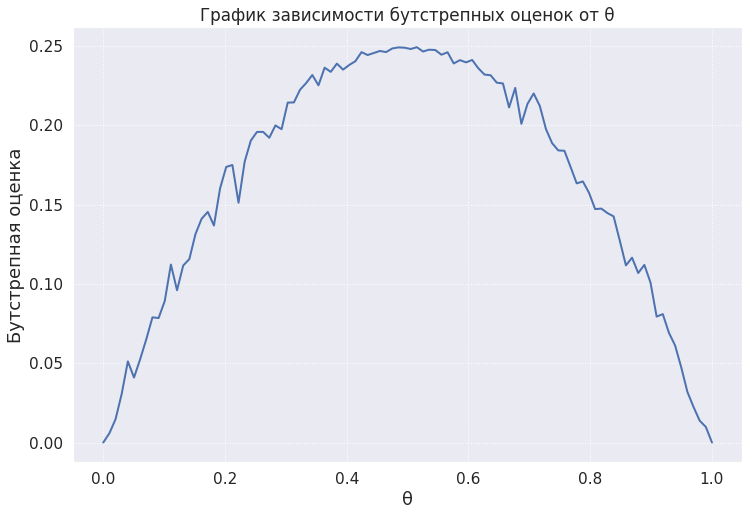

In [124]:
plt.figure(figsize=(12, 8))
plt.plot(grid, bootstrap_estimates, lw=2)
plt.grid(ls=':')
plt.xlabel('θ', fontsize=18)
plt.ylabel('Бутстрепная оценка', fontsize=18)
plt.title('График зависимости бутстрепных оценок от θ')
plt.show()

**Вывод**

Бутстрепная оценка дисперсии эффективной оценки хорошо приближает нижную оценку дисперсии из нер-ва Рао-Крамера